In [1]:
import pandas as pd
import numpy as np
import time
from pycaret.classification import *

In [2]:
import gc
gc.collect()

20

In [3]:
dataset = pd.read_csv('/Users/DAHS/MIMIC-IV-Data-Pipeline/MIMIC_pipeline/Case Labeling/mimic_df.csv.gz', index_col = 0, compression='gzip')

In [4]:
import gc
gc.collect()
preproc = pd.read_csv("/Users/DAHS/MIMIC-IV-Data-Pipeline/mimiciv/2.2/icu/procedureevents.csv.gz", index_col = 0, compression='gzip')

In [5]:
demo = pd.read_csv('/Users/DAHS/MIMIC-IV-Data-Pipeline/data/cohort/cohort_icu_mortality_0_.csv.gz', index_col = 0, compression='gzip')

In [6]:
new = preproc.merge(demo[['intime', 'stay_id']], how='inner', left_on='stay_id', right_on='stay_id')

In [7]:
new.intime = pd.to_datetime(new.intime)
new.starttime = pd.to_datetime(new.starttime)
new.endtime = pd.to_datetime(new.endtime)

new['start_time'] = new['starttime'] - new['intime']
new['end_time'] = new['endtime'] - new['intime']

In [8]:
new['start_time']=new['start_time'].astype(str)
new['end_time']=new['end_time'].astype(str)

new[['start_days', 'dummy','start_hours']] = new['start_time'].str.split(' ', -1, expand=True)
new[['start_hours','min','sec']] = new['start_hours'].str.split(':', -1, expand=True)
new['start_time']=pd.to_numeric(new['start_days'])*24+pd.to_numeric(new['start_hours'])
new[['start_days', 'dummy','start_hours']] = new['end_time'].str.split(' ', -1, expand=True)
new[['start_hours','min','sec']] = new['start_hours'].str.split(':', -1, expand=True)
new['stop_time']=pd.to_numeric(new['start_days'])*24+pd.to_numeric(new['start_hours'])
new=new.drop(columns=['start_days', 'dummy','start_hours','min','sec'])

In [9]:
#####Sanity check
new['sanity']=new['stop_time']-new['start_time']
new=new[new['sanity']>0]
del new['sanity']

In [10]:
preproc = new[new.stay_id.isin(dataset.stay_id.unique())]

In [11]:
preproc = preproc[['stay_id', 'itemid', 'start_time', 'stop_time']].copy()

In [12]:
recovery_situation = {0, 1, 2, 3}
deterioration_situation = {0, 1, 3}

    
recover_state = dataset[dataset['classes'].isin(recovery_situation)].groupby('stay_id')['classes'].nunique()
recover_state = recover_state[recover_state == len(recovery_situation)].index

recover_set = dataset[dataset['stay_id'].isin(recover_state)]

deterioration_state = dataset[dataset['classes'].isin(deterioration_situation)].groupby('stay_id')['classes'].nunique()
deterioration_state = deterioration_state[deterioration_state == len(deterioration_situation)].index

deterioration_set = dataset[dataset['stay_id'].isin(deterioration_state)]

def filter_classes_with_condition(df):
    filtered_df = df[df['classes'].isin([0, 1, 3])]
    return filtered_df

deterioration_set = filter_classes_with_condition(deterioration_set)

deterioration_grouped = deterioration_set.groupby('stay_id')

# 조건에 맞는 stay_id를 찾는 함수
def deterioration_filter_stay_ids(group):
    # 처음 3개 관측치의 Annotation이 모두 'no_circ'인지 확인
    if all(group.head(3)['Annotation'] == 'no_circ'):
        # 마지막 관측치의 classes가 3인지 확인
        if group.tail(1)['classes'].iloc[0] == 3:
            return True
    return False

# 조건을 만족하는 stay_id 필터링
valid_stay_ids = [name for name, group in deterioration_grouped if deterioration_filter_stay_ids(group)]
deterioration_df = deterioration_set[deterioration_set.stay_id.isin(valid_stay_ids)].copy()

recover_grouped = recover_set.groupby('stay_id')

def recovery_filter_stay_ids(group):
    # 처음 3개 관측치의 Annotation이 모두 'no_circ'인 경우만 고려
    if all(group.head(3)['Annotation'] == 'no_circ'):
        # 'classes'가 2인 마지막 관측치 찾기
        last_class_2_index = group[group['classes'] == 2].index.max()
        if pd.notna(last_class_2_index):
            # 해당 인덱스까지의 데이터 반환
            return group.loc[:last_class_2_index]
    return pd.DataFrame()

# 조건을 만족하는 데이터 필터링
recovery_df = pd.concat([recovery_filter_stay_ids(group) for _, group in recover_grouped])

In [14]:
recovery_df['label'] = 'recover'
deterioration_df['label'] = 'deter'

target_data = pd.concat([recovery_df.drop('classes', axis= 1), deterioration_df.drop('classes', axis = 1)])
embedding = pd.read_csv('/Users/DAHS/MIMIC-IV-Data-Pipeline/MIMIC_pipeline/Visualization/contrastive_data_space_case3_4.csv', compression='gzip')

total = pd.concat([embedding.reset_index(drop=True), target_data.reset_index(drop=True)], axis = 1)

In [39]:
#<공통>
# 관측치의 다섯번째 시점부터 circ인 stay_id 제외
#<recovery>
# classes가 2인 마지막 인덱스까지만 선택
# 시각화에 좋을 것 같은 stay_id : 30509726

#<deterioration>
# 마지막 관측치가 classes 3 인 데이터셋 선택
# 시각화에 좋을 것 같은 stay_id : 30094655

In [15]:
new_deterioration_df = total[total['label']=='deter']
new_recovery_df = total[total['label']=='recover']

In [18]:
def make_fluids_treatment(data):
    
    df = data.copy()
    
    # 'IV fluid High', 'IV fluid Low', 'IV fluid None' 
    df['IV fluid High'] = 0
    df['IV fluid Low'] = 0
    df['IV fluid None'] = 0
    
    df.loc[df['Fluids(ml)'] >= 287, 'IV fluid High'] = 1
    df.loc[(df['Fluids(ml)'] > 0) & (df['Fluids(ml)'] < 287), 'IV fluid Low'] = 1
    df.loc[df['Fluids(ml)'] == 0, 'IV fluid None'] = 1

    return df


new_deterioration_df = make_fluids_treatment(new_deterioration_df)
new_recovery_df = make_fluids_treatment(new_recovery_df)

In [19]:
preproc = preproc[(preproc['itemid'] == 225792)|(preproc['itemid'] == 225794)]

In [20]:
preproc['itemid'] = preproc['itemid'].map({225792:'Ventilation', 225794 : 'Ventilation'})
preproc

,stay_id,itemid,start_time,stop_time
80,35479615,Ventilation,1,211
95,38875437,Ventilation,1,70
114,36753294,Ventilation,23,29
139,31831386,Ventilation,1,18
165,32128372,Ventilation,-1,62
...,...,...,...,...
695873,34531437,Ventilation,2,6
695969,30988867,Ventilation,-1,78
696004,35165301,Ventilation,67,81
696013,35165301,Ventilation,29,65


In [21]:
# Adding a new column 'Ventilation' in the ICU dataframe, initialized with 0
new_deterioration_df['Ventilation'] = 0

# Iterating over the ventilation dataframe to update the 'Ventilation' column in ICU dataframe
for index, row in preproc.iterrows():
    stay_id = row['stay_id']
    start_time = row['start_time']
    stop_time = row['stop_time']

    # Updating the 'Ventilation' column based on the ventilation period
    mask = (new_deterioration_df['stay_id'] == stay_id) & (new_deterioration_df['Time_since_ICU_admission'] >= start_time) & (new_deterioration_df['Time_since_ICU_admission'] <= stop_time)
    new_deterioration_df.loc[mask, 'Ventilation'] = 1

In [22]:
# Adding a new column 'Ventilation' in the ICU dataframe, initialized with 0
new_recovery_df['Ventilation'] = 0

# Iterating over the ventilation dataframe to update the 'Ventilation' column in ICU dataframe
for index, row in preproc.iterrows():
    stay_id = row['stay_id']
    start_time = row['start_time']
    stop_time = row['stop_time']

    # Updating the 'Ventilation' column based on the ventilation period
    mask = (new_recovery_df['stay_id'] == stay_id) & (new_recovery_df['Time_since_ICU_admission'] >= start_time) & (new_recovery_df['Time_since_ICU_admission'] <= stop_time)
    new_recovery_df.loc[mask, 'Ventilation'] = 1

In [59]:
new_deterioration_df['Catheter']

49275     0
49276     0
49277     0
49278     0
49279     0
         ..
125470    0
125471    0
125472    0
125473    0
125474    0
Name: Catheter, Length: 76200, dtype: int64

In [135]:
def make_treatment_strategy_septic(data):
    df = data.copy()

    tm_0 = (df['Ventilation']==0) & (df['IV fluid None']==1) & (df['vasoactive/inotropic']==0) & (df['Antibiotics']==0)
    tm_1 = (df['Ventilation']==0) & (df['IV fluid None']==1) & (df['vasoactive/inotropic']==0) & (df['Antibiotics']==1)
    
    tm_2 = (df['Ventilation']==0) & (df['IV fluid None']==1) & (df['vasoactive/inotropic']==1) & (df['Antibiotics']==0)
    tm_3 = (df['Ventilation']==0) & (df['IV fluid None']==1) & (df['vasoactive/inotropic']==1) & (df['Antibiotics']==1)
    
    tm_4 = (df['Ventilation']==1) & (df['IV fluid None']==1) & (df['vasoactive/inotropic']==0) & (df['Antibiotics']==0)
    tm_5 = (df['Ventilation']==1) & (df['IV fluid None']==1) & (df['vasoactive/inotropic']==0) & (df['Antibiotics']==1)
    
    tm_6 = (df['Ventilation']==1) & (df['IV fluid None']==1) & (df['vasoactive/inotropic']==1) & (df['Antibiotics']==0)
    tm_7 = (df['Ventilation']==1) & (df['IV fluid None']==1) & (df['vasoactive/inotropic']==1) & (df['Antibiotics']==1)
    
    tm_8 = (df['Ventilation']==0) & (df['IV fluid Low']==1) & (df['vasoactive/inotropic']==0) & (df['Antibiotics']==0)
    tm_9 = (df['Ventilation']==0) & (df['IV fluid Low']==1) & (df['vasoactive/inotropic']==0) & (df['Antibiotics']==1)
    
    tm_10 = (df['Ventilation']==0) & (df['IV fluid Low']==1) & (df['vasoactive/inotropic']==1) & (df['Antibiotics']==0)
    tm_11 = (df['Ventilation']==0) & (df['IV fluid Low']==1) & (df['vasoactive/inotropic']==1) & (df['Antibiotics']==1)
    
    tm_12 = (df['Ventilation']==1) & (df['IV fluid Low']==1) & (df['vasoactive/inotropic']==0) & (df['Antibiotics']==0)
    tm_13 = (df['Ventilation']==1) & (df['IV fluid Low']==1) & (df['vasoactive/inotropic']==0) & (df['Antibiotics']==1)
    
    tm_14 = (df['Ventilation']==1) & (df['IV fluid Low']==1) & (df['vasoactive/inotropic']==1) & (df['Antibiotics']==0)
    tm_15 = (df['Ventilation']==1) & (df['IV fluid Low']==1) & (df['vasoactive/inotropic']==1) & (df['Antibiotics']==1)
    
    tm_16 = (df['Ventilation']==0) & (df['IV fluid High']==1) & (df['vasoactive/inotropic']==0) & (df['Antibiotics']==0)
    tm_17 = (df['Ventilation']==0) & (df['IV fluid High']==1) & (df['vasoactive/inotropic']==1) & (df['Antibiotics']==1)
    
    tm_18 = (df['Ventilation']==1) & (df['IV fluid High']==1) & (df['vasoactive/inotropic']==0) & (df['Antibiotics']==0)
    tm_19 = (df['Ventilation']==1) & (df['IV fluid High']==1) & (df['vasoactive/inotropic']==1) & (df['Antibiotics']==1)
    
    conditions = [tm_0, tm_1, tm_2, tm_3, tm_4, tm_5,
                  tm_6, tm_7, tm_8, tm_9, tm_10,
                  tm_11, tm_12, tm_13, tm_14,
                  tm_15, tm_16, tm_17, tm_18,tm_19]
    
    actions = np.arange(20)
    df['Action_septic'] = np.select(conditions, actions, default=0)
    
    return df[['stay_id', 'Time_since_ICU_admission', 'Annotation', 'classes' ,'Action_septic', 'Acute_Myocardial_Infarction', 'End-Stage_Cardiomyopathy','IABP', 'Impella', 'ECMO',
               'Adv__Valvular_HD', 'Myocarditis', 'Arrhythmia', 'Pulmonary_Embolism', 'Tension_Pneumothorax', 'hypovolemia_external', 'hypovolemia_internal','Lactate', 'MAP',
               'sepsis', 'Lactate_3', 'Lactate_5', 'Lactate_1', 'vasoactive/inotropic', 'Ventilation', 'Fluids(ml)', 'MAP_1','MAP_3', 'MAP_5', 'component 0', 'component 1', 'IV fluid High', 'IV fluid Low', 'IV fluid None']]
    
def make_treatment_strategy_nonseptic(data):
    df = data.copy()

    tm_0 = (df['Ventilation']==0) & (df['IV fluid None']==1) & (df['vasoactive/inotropic']==0) 
    
    tm_1 = (df['Ventilation']==0) & (df['IV fluid None']==1) & (df['vasoactive/inotropic']==1)
    
    tm_2 = (df['Ventilation']==1) & (df['IV fluid None']==1) & (df['vasoactive/inotropic']==0)
    
    tm_3 = (df['Ventilation']==1) & (df['IV fluid None']==1) & (df['vasoactive/inotropic']==1) 
    
    tm_4 = (df['Ventilation']==0) & (df['IV fluid Low']==1) & (df['vasoactive/inotropic']==0) 
    
    tm_5 = (df['Ventilation']==0) & (df['IV fluid Low']==1) & (df['vasoactive/inotropic']==1) 
    
    tm_6= (df['Ventilation']==1) & (df['IV fluid Low']==1) & (df['vasoactive/inotropic']==0)
    
    tm_7 = (df['Ventilation']==1) & (df['IV fluid Low']==1) & (df['vasoactive/inotropic']==1) 
    
    tm_8 = (df['Ventilation']==0) & (df['IV fluid High']==1) & (df['vasoactive/inotropic']==0)
    
    tm_9 = (df['Ventilation']==1) & (df['IV fluid High']==1) & (df['vasoactive/inotropic']==0) 
    
    tm_10 = (df['Ventilation']==0) & (df['IV fluid High']==1) & (df['vasoactive/inotropic']==1)
    
    tm_11 = (df['Ventilation']==1) & (df['IV fluid High']==1) & (df['vasoactive/inotropic']==1) 
    
    conditions = [tm_0, tm_1, tm_2, tm_3, tm_4, tm_5,
                  tm_6, tm_7, tm_8, tm_9, tm_10, tm_11]
    
    actions = np.arange(12)
    df['Action_nonseptic'] = np.select(conditions, actions, default=0)
    
    return df[['stay_id', 'Time_since_ICU_admission', 'Annotation', 'classes' , 'Acute_Myocardial_Infarction', 'End-Stage_Cardiomyopathy','IABP', 'Impella', 'ECMO',
               'Adv__Valvular_HD', 'Myocarditis', 'Arrhythmia', 'Pulmonary_Embolism', 'Tension_Pneumothorax', 'hypovolemia_external', 'hypovolemia_internal','Lactate', 'MAP',
               'sepsis', 'Lactate_3', 'Lactate_5', 'Lactate_1', 'vasoactive/inotropic', 'Ventilation', 'Fluids(ml)', 'MAP_1','MAP_3', 'MAP_5', 'component 0', 'component 1', 'IV fluid High', 'IV fluid Low', 'IV fluid None', 'Action_nonseptic', 'Action_septic']]

det_df = make_treatment_strategy_septic(new_deterioration_df)
re_df = make_treatment_strategy_septic(new_recovery_df)

det_df = make_treatment_strategy_nonseptic(det_df)
re_df = make_treatment_strategy_nonseptic(re_df)

In [136]:
# cardiognic -> vasoactive/inotropic 사용 중이며, 기계적 순환 지원이 1번이라도 있었으면 cardiogenic shock로 정의 하였음

re_df['cardiogenic_factor'] = re_df[['Acute_Myocardial_Infarction', 'End-Stage_Cardiomyopathy','Adv__Valvular_HD', 'Myocarditis', 'Arrhythmia']].sum(axis = 1)
re_df['cardiogenic_factor'] = re_df['cardiogenic_factor'].apply(lambda x: 1 if not pd.isna(x) and x > 0 else 0)

re_df['mechanical_support'] = re_df[['IABP', 'Impella', 'ECMO']].sum(axis = 1)
re_df['mechanical_support'] = re_df['mechanical_support'].apply(lambda x: 1 if not pd.isna(x) and x > 0 else 0)

mec_su = re_df[['stay_id', 'mechanical_support']].groupby('stay_id').sum().reset_index()
mec_su['mechanical_support'] = mec_su['mechanical_support'].apply(lambda x: 1 if not pd.isna(x) and x > 0 else 0)

area_dict = dict(zip(mec_su.stay_id, mec_su.mechanical_support))
re_df['mechanical_support'] = re_df.stay_id.copy()
re_df['mechanical_support'] = re_df['mechanical_support'].map(area_dict)

re_df['cardiogenic_factor'] = re_df['cardiogenic_factor'] + re_df['mechanical_support']
re_df['cardiogenic_factor'] = re_df['cardiogenic_factor'].apply(lambda x: 1 if not pd.isna(x) and x > 0 else 0)

re_df['hypovolemia_factor'] = re_df[['hypovolemia_external', 'hypovolemia_internal']].sum(axis = 1)
re_df['hypovolemia_factor'] = re_df['hypovolemia_factor'].apply(lambda x: 1 if not pd.isna(x) and x > 0 else 0)

re_df['obstruction_factor'] = re_df[['Pulmonary_Embolism', 'Tension_Pneumothorax']].sum(axis = 1)
re_df['obstruction_factor'] = re_df['obstruction_factor'].apply(lambda x: 1 if not pd.isna(x) and x > 0 else 0)

re_df['distributive_factor'] = re_df['sepsis'].copy()


det_df['cardiogenic_factor'] = det_df[['Acute_Myocardial_Infarction', 'End-Stage_Cardiomyopathy','Adv__Valvular_HD', 'Myocarditis', 'Arrhythmia']].sum(axis = 1)
det_df['cardiogenic_factor'] = det_df['cardiogenic_factor'].apply(lambda x: 1 if not pd.isna(x) and x > 0 else 0)

det_df['mechanical_support'] = det_df[['IABP', 'Impella', 'ECMO']].sum(axis = 1)
det_df['mechanical_support'] = det_df['mechanical_support'].apply(lambda x: 1 if not pd.isna(x) and x > 0 else 0)
mec_su = det_df[['stay_id', 'mechanical_support']].groupby('stay_id').sum().reset_index()
mec_su['mechanical_support'] = mec_su['mechanical_support'].apply(lambda x: 1 if not pd.isna(x) and x > 0 else 0)

area_dict = dict(zip(mec_su.stay_id, mec_su.mechanical_support))
det_df['mechanical_support'] = det_df.stay_id.copy()
det_df['mechanical_support'] = det_df['mechanical_support'].map(area_dict)

det_df['cardiogenic_factor'] = det_df['cardiogenic_factor'] + det_df['mechanical_support']
det_df['cardiogenic_factor'] = det_df['cardiogenic_factor'].apply(lambda x: 1 if not pd.isna(x) and x > 0 else 0)

det_df['hypovolemia_factor'] = det_df[['hypovolemia_external', 'hypovolemia_internal']].sum(axis = 1)
det_df['hypovolemia_factor'] = det_df['hypovolemia_factor'].apply(lambda x: 1 if not pd.isna(x) and x > 0 else 0)

det_df['obstruction_factor'] = det_df[['Pulmonary_Embolism', 'Tension_Pneumothorax']].sum(axis = 1)
det_df['obstruction_factor'] = det_df['obstruction_factor'].apply(lambda x: 1 if not pd.isna(x) and x > 0 else 0)

det_df['distributive_factor'] = det_df['sepsis'].copy()

In [137]:
# 1개 조합

for_plot_re_df = re_df[['stay_id', 'Time_since_ICU_admission', 'vasoactive/inotropic', 'Ventilation', 'IV fluid High', 'IV fluid Low', 'IV fluid None', 'cardiogenic_factor', 'hypovolemia_factor',
                        'obstruction_factor', 'distributive_factor', 'Annotation', 'component 0', 'component 1','Lactate', 'Lactate_1', 'Lactate_3', 'Lactate_5','MAP', 'MAP_1', 'MAP_3', 'MAP_5', 'classes', 'Action_nonseptic', 'Action_septic']].copy()

for_plot_det_df = det_df[['stay_id', 'Time_since_ICU_admission', 'vasoactive/inotropic', 'Ventilation', 'IV fluid High', 'IV fluid Low', 'IV fluid None', 'cardiogenic_factor', 'hypovolemia_factor',
                        'obstruction_factor', 'distributive_factor', 'Annotation', 'component 0', 'component 1','Lactate','Lactate_1', 'Lactate_3', 'Lactate_5','MAP', 'MAP_1', 'MAP_3', 'MAP_5', 'classes', 'Action_nonseptic', 'Action_septic']].copy()
# hypovolemia only

hypovolemia_recover = for_plot_re_df[(for_plot_re_df['hypovolemia_factor']==1)&(for_plot_re_df['cardiogenic_factor']==0)&(for_plot_re_df['obstruction_factor']==0)&(for_plot_re_df['distributive_factor']==0)]
hypovolemia_deterio = for_plot_det_df[(for_plot_det_df['hypovolemia_factor']==1)&(for_plot_det_df['cardiogenic_factor']==0)&(for_plot_det_df['obstruction_factor']==0)&(for_plot_det_df['distributive_factor']==0)]

shock_time_hypovolemia_recover_cohort = []

for stay in hypovolemia_recover.stay_id.unique():
    targ = hypovolemia_recover[hypovolemia_recover['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_hypovolemia_recover_cohort.append(shock_time)
    
mean_shock_time_hypovolemia_recover_cohort = sum(shock_time_hypovolemia_recover_cohort) / len(shock_time_hypovolemia_recover_cohort)

shock_time_hypovolemia_deterio_cohort = []

for stay in hypovolemia_deterio.stay_id.unique():
    targ = hypovolemia_deterio[hypovolemia_deterio['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_hypovolemia_deterio_cohort.append(shock_time)
    
mean_shock_time_hypovolemia_deterio_cohort = sum(shock_time_hypovolemia_deterio_cohort) / len(shock_time_hypovolemia_deterio_cohort)

print('저혈량성 쇼크 only stay:' ,len(shock_time_hypovolemia_recover_cohort) + len(shock_time_hypovolemia_deterio_cohort))
print('저혈량성 쇼크 회복 군집 쇼크 지속시간:' ,mean_shock_time_hypovolemia_recover_cohort)
print('저혈량성 쇼크 악화 군집 쇼크 지속시간:', mean_shock_time_hypovolemia_deterio_cohort)


저혈량성 쇼크 only stay: 56
저혈량성 쇼크 회복 군집 쇼크 지속시간: 19.9375
저혈량성 쇼크 악화 군집 쇼크 지속시간: 37.666666666666664


In [138]:
# cardiogenic only

cardiogenic_recover = for_plot_re_df[(for_plot_re_df['hypovolemia_factor']==0)&(for_plot_re_df['cardiogenic_factor']==1)&(for_plot_re_df['obstruction_factor']==0)&(for_plot_re_df['distributive_factor']==0)]
cardiogenic_deterio = for_plot_det_df[(for_plot_det_df['hypovolemia_factor']==0)&(for_plot_det_df['cardiogenic_factor']==1)&(for_plot_det_df['obstruction_factor']==0)&(for_plot_det_df['distributive_factor']==0)]

shock_time_cardiogenic_recover_cohort = []

for stay in cardiogenic_recover.stay_id.unique():
    targ = cardiogenic_recover[cardiogenic_recover['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_cardiogenic_recover_cohort.append(shock_time)
    
mean_shock_time_cardiogenic_recover_cohort = sum(shock_time_cardiogenic_recover_cohort) / len(shock_time_cardiogenic_recover_cohort)

shock_time_cardiogenic_deterio_cohort = []

for stay in cardiogenic_deterio.stay_id.unique():
    targ = cardiogenic_deterio[cardiogenic_deterio['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_cardiogenic_deterio_cohort.append(shock_time)
    
mean_shock_time_cardiogenic_deterio_cohort = sum(shock_time_cardiogenic_deterio_cohort) / len(shock_time_cardiogenic_deterio_cohort)

print('심장성 쇼크 only stay:' ,len(shock_time_cardiogenic_recover_cohort) + len(shock_time_cardiogenic_deterio_cohort))
print('심장성 쇼크 회복 군집 쇼크 지속시간:' ,mean_shock_time_cardiogenic_recover_cohort)
print('심장성 쇼크 악화 군집 쇼크 지속시간:', mean_shock_time_cardiogenic_deterio_cohort)

심장성 쇼크 only stay: 279
심장성 쇼크 회복 군집 쇼크 지속시간: 14.83084577114428
심장성 쇼크 악화 군집 쇼크 지속시간: 32.65384615384615


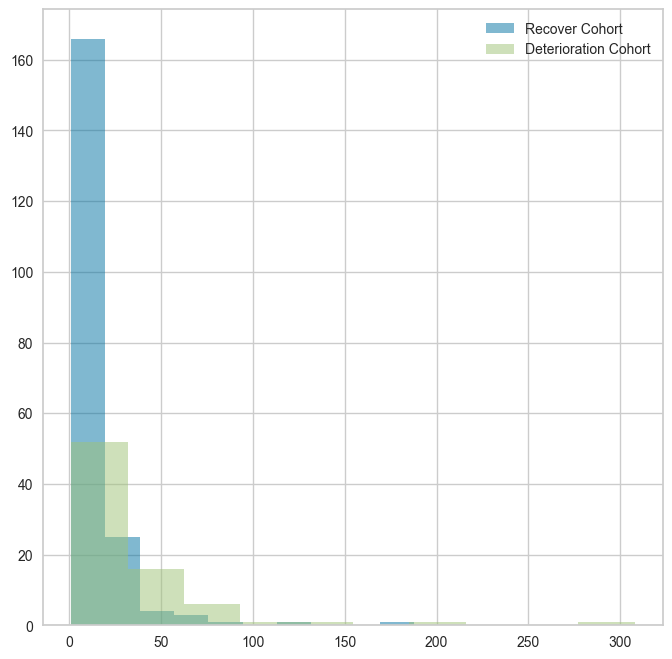

Mann-Whitney U test p-value: 0.0011878242387400758


In [139]:
# 통계적으로 유의미 한지
import matplotlib.pyplot as plt
from scipy import stats
plt.rcParams["figure.figsize"] = (8,8)
# 데이터 분포 시각화
plt.hist(shock_time_cardiogenic_recover_cohort, alpha=0.5, label='Recover Cohort')
plt.hist(shock_time_cardiogenic_deterio_cohort, alpha=0.5, label='Deterioration Cohort')
plt.legend()
plt.show()

# Mann-Whitney U test
u_stat, p_val_mw = stats.mannwhitneyu(shock_time_cardiogenic_recover_cohort, shock_time_cardiogenic_deterio_cohort)
print("Mann-Whitney U test p-value:", p_val_mw)

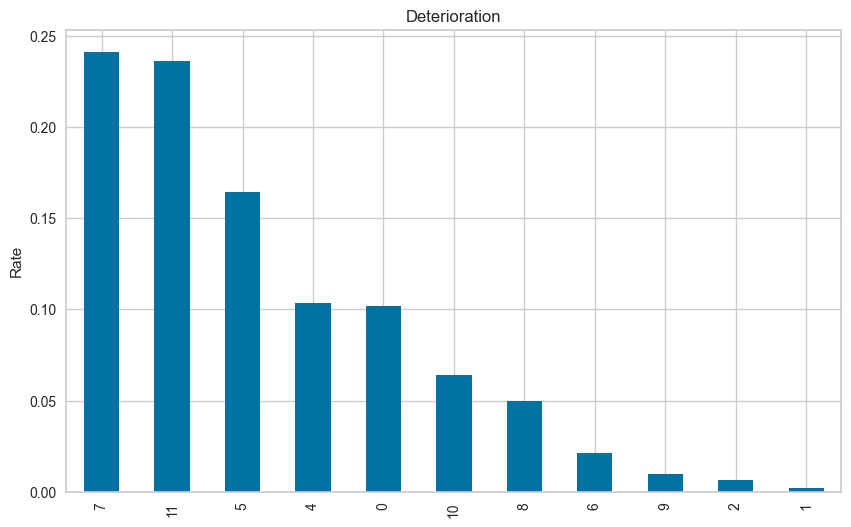

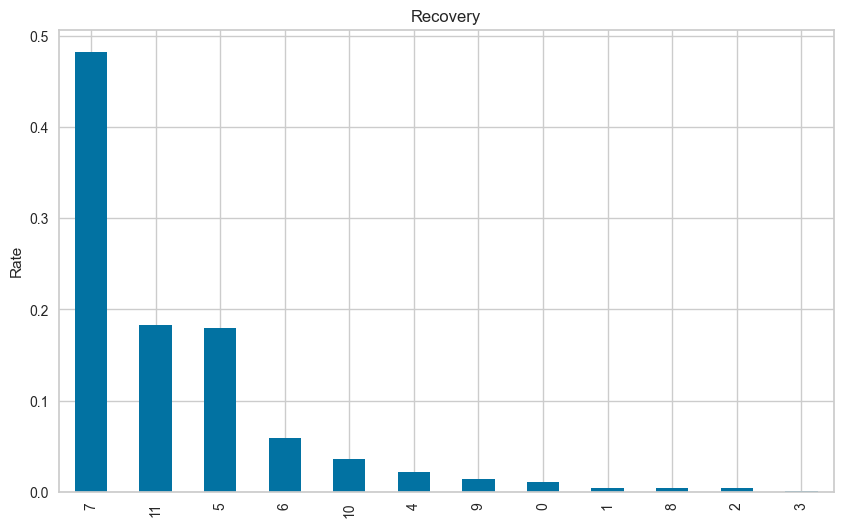

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns

# det_df의 Action 비율
det_action_counts = cardiogenic_deterio[cardiogenic_deterio['Annotation']=='circ']['Action_nonseptic'].value_counts(normalize=True)
det_action_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Deterioration')
plt.ylabel('Rate')
plt.show()

# re_df의 Action 비율
re_action_counts = cardiogenic_recover[cardiogenic_recover['Annotation']=='circ']['Action_nonseptic'].value_counts(normalize=True)
re_action_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Recovery')
plt.ylabel('Rate')
plt.show()

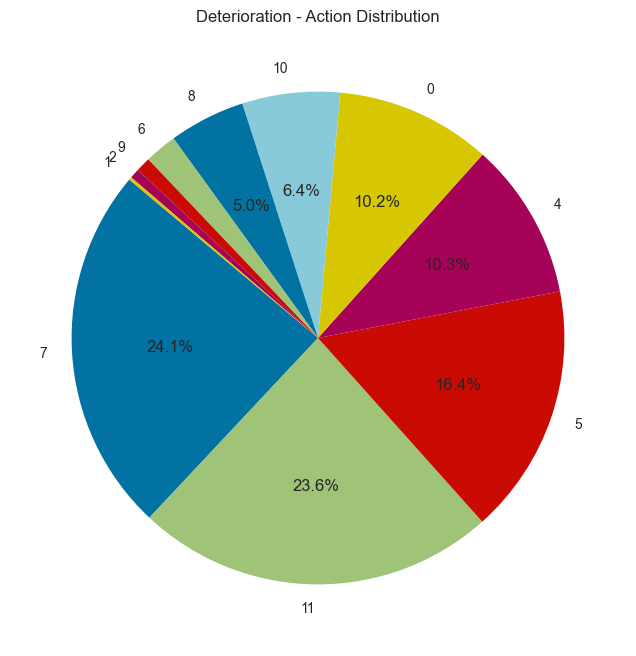

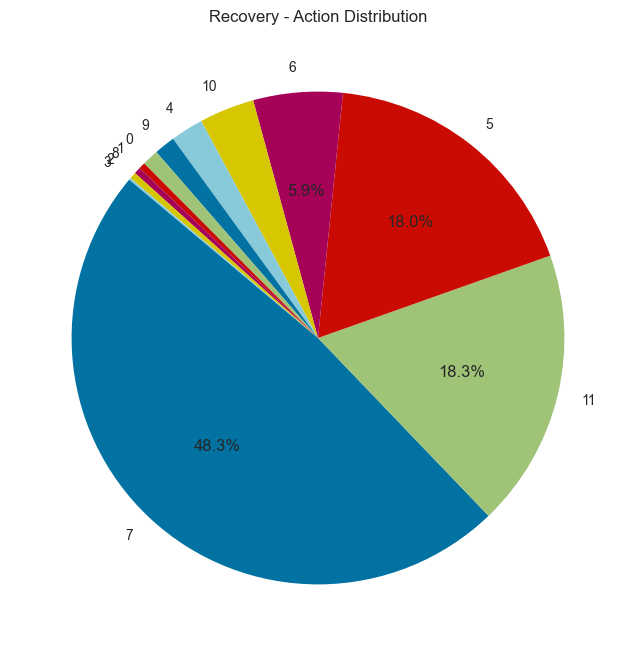

In [141]:
import matplotlib.pyplot as plt
det_action_counts = cardiogenic_deterio[cardiogenic_deterio['Annotation']=='circ']['Action_nonseptic'].value_counts(normalize=True)
re_action_counts = cardiogenic_recover[cardiogenic_recover['Annotation']=='circ']['Action_nonseptic'].value_counts(normalize=True)

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        if pct >= 5: # 10% 이상인 경우에만 백분율 표시
            return '{p:.1f}%'.format(p=pct)
        else:
            return '' # 10% 미만인 경우에는 비워두기
    return my_autopct

# det_df의 Action 비율을 원형 다이어그램으로 표현
plt.figure(figsize=(8, 8))
plt.pie(det_action_counts, labels=det_action_counts.index, autopct=make_autopct(det_action_counts), startangle=140)
plt.title('Deterioration - Action Distribution')
plt.show()

# re_df의 Action 비율을 원형 다이어그램으로 표현
plt.figure(figsize=(8, 8))
plt.pie(re_action_counts, labels=re_action_counts.index, autopct=make_autopct(re_action_counts), startangle=140)
plt.title('Recovery - Action Distribution')
plt.show()



In [165]:
det_vip = cardiogenic_deterio[(cardiogenic_deterio['Action_nonseptic']==7)|(cardiogenic_deterio['Action_nonseptic']==11)|(cardiogenic_deterio['Action_nonseptic']==5)]
det_vip['CASE'] = 4

det_vip = det_vip.groupby('stay_id').filter(lambda x: len(x) >= 20)


re_vip = cardiogenic_recover[(cardiogenic_recover['Action_nonseptic']==7)|(cardiogenic_recover['Action_nonseptic']==11)|(cardiogenic_recover['Action_nonseptic']==5)]
re_vip['CASE'] = 3

re_vip = re_vip.groupby('stay_id').filter(lambda x: len(x) >= 20)

cardiogenic = pd.concat([det_vip, re_vip])

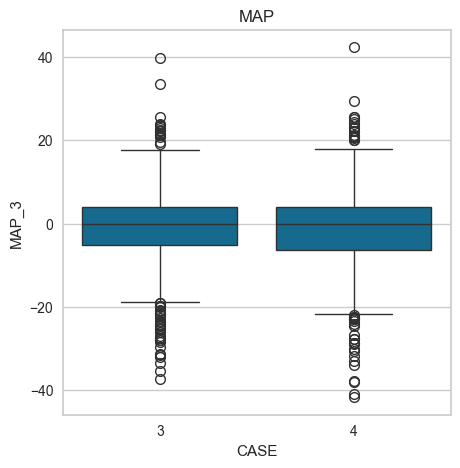

In [166]:
# det_df의 Action 별 Time_since_ICU_admission 분포
plt.figure(figsize=(5, 5))
sns.boxplot(x='CASE', y='MAP_3', data= cardiogenic)
plt.title('MAP')
plt.show()

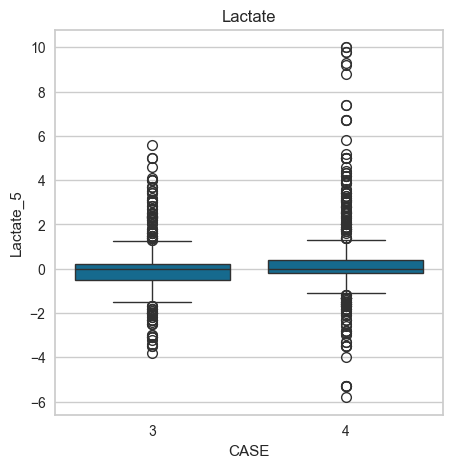

In [168]:
plt.figure(figsize=(5, 5))
sns.boxplot(x='CASE', y='Lactate_5', data= cardiogenic)
plt.title('Lactate')
plt.show()

In [191]:
total_cardio = pd.concat([cardiogenic_recover, cardiogenic_deterio])

In [198]:
cardiogenic[cardiogenic['Annotation']=='circ']['component 0'].mean()

10.525903844604862

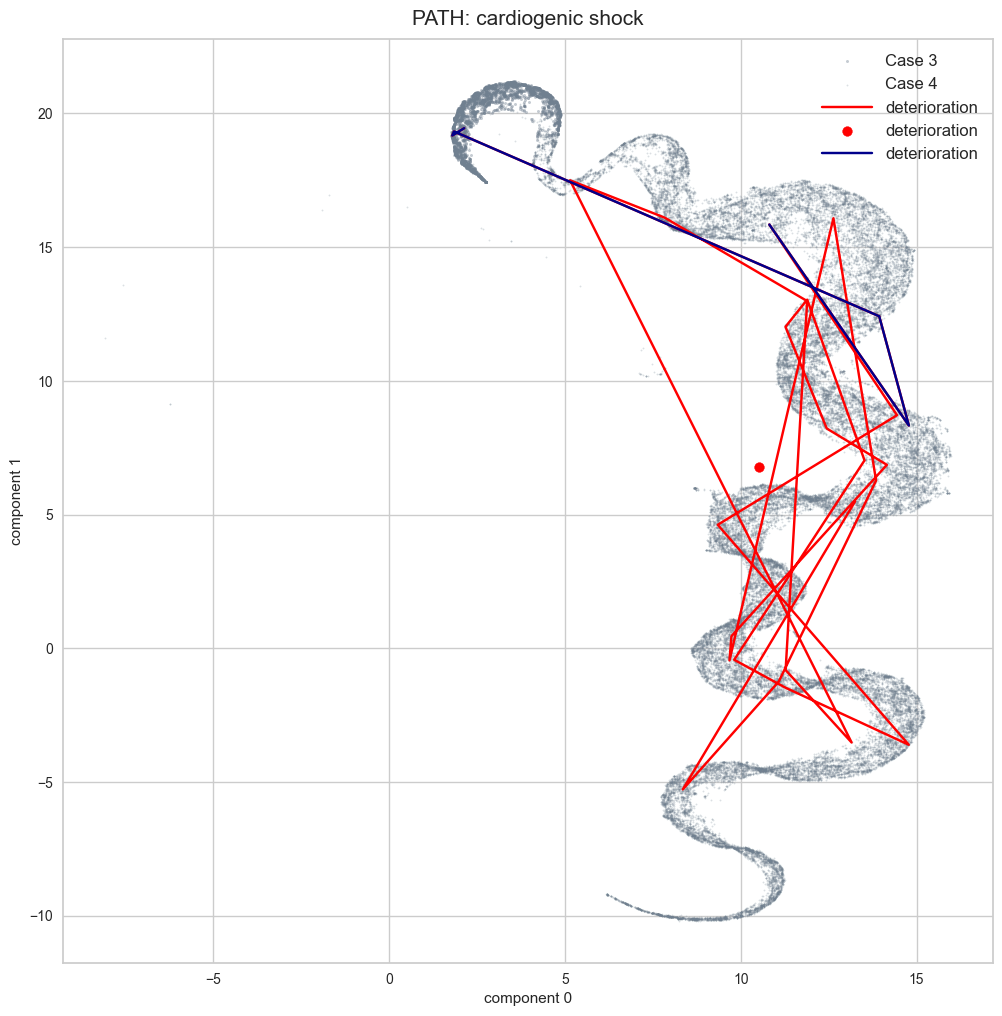

In [219]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,12)
# target 별 분리
c_tsne_df_0 = total[total['classes'] == 0]
c_tsne_df_1 = total[total['classes'] == 1]
c_tsne_df_2 = total[total['classes'] == 2]
c_tsne_df_3 = total[total['classes'] == 3]

# # target 별 시각화
# plt.scatter(c_tsne_df_0['component 0'], c_tsne_df_0['component 1'], color = 'y', label = 'Case 1', s = 2, alpha=0.2)
# plt.scatter(c_tsne_df_1['component 0'], c_tsne_df_1['component 1'], color = 'darkcyan', label = 'Case 2', s = 2, alpha=0.4)
plt.scatter(c_tsne_df_2['component 0'], c_tsne_df_2['component 1'], color = 'slategray', label = 'Case 3', s = 3, alpha=0.4)
plt.scatter(c_tsne_df_3['component 0'], c_tsne_df_3['component 1'], color = 'slategray', label = 'Case 4', s = 1, alpha=0.2)


stay_1 = cardiogenic_recover[cardiogenic_recover['stay_id']==39568167] #39568167
# stay_2 = cardiogenic_deterio[cardiogenic_deterio['stay_id']==cardiogenic_deterio.stay_id.unique()[10]]

# plt.scatter(stay_1['component 0'], stay_1['component 1'], color = 'darkblue', label = 'recover')



plt.plot(stay_1[stay_1['Annotation']=='circ']['component 0'], stay_1[stay_1['Annotation']=='circ']['component 1'], color = 'red', label = 'deterioration')
plt.scatter(cardiogenic[cardiogenic['Annotation']=='circ']['component 0'].mean(), cardiogenic[cardiogenic['Annotation']=='circ']['component 1'].mean(), color = 'red', label = 'deterioration')
plt.plot(stay_1.iloc[-6:,:][stay_1.iloc[-6:,:]['Annotation']=='circ']['component 0'], stay_1.iloc[-6:,:][stay_1.iloc[-6:,:]['Annotation']=='circ']['component 1'], color = 'darkblue', label = 'deterioration')
# plt.scatter(cardiogenic[cardiogenic['Annotation']=='circ']['component 0'].mean(), cardiogenic[cardiogenic['Annotation']=='circ']['component 1'].mean(), color = 'red', label = 'deterioration', s = 10)

plt.title('PATH: cardiogenic shock', pad = 10, fontsize=15)
plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend(fontsize=12, handlelength=3)
plt.show()

In [217]:
stay_1.iloc[-9:,:][['Lactate_3', 'classes']]

,Lactate_3,classes
47971,3.700000,3
47972,2.133333,3
47973,1.000000,3
47974,-1.700000,3
47975,-1.700000,3
47976,-3.200000,3
47977,-0.700000,2
47978,-0.700000,2
47979,-0.500000,2


In [103]:
# obstruction only

obstruction_recover = for_plot_re_df[(for_plot_re_df['hypovolemia_factor']==0)&(for_plot_re_df['cardiogenic_factor']==0)&(for_plot_re_df['obstruction_factor']==1)&(for_plot_re_df['distributive_factor']==0)]
obstruction_deterio = for_plot_det_df[(for_plot_det_df['hypovolemia_factor']==0)&(for_plot_det_df['cardiogenic_factor']==0)&(for_plot_det_df['obstruction_factor']==1)&(for_plot_det_df['distributive_factor']==0)]

shock_time_obstruction_recover_cohort = []

for stay in obstruction_recover.stay_id.unique():
    targ = obstruction_recover[obstruction_recover['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_obstruction_recover_cohort.append(shock_time)
    
mean_shock_time_obstruction_recover_cohort = sum(shock_time_obstruction_recover_cohort) / len(shock_time_obstruction_recover_cohort)

shock_time_obstruction_deterio_cohort = []

for stay in obstruction_deterio.stay_id.unique():
    targ = obstruction_deterio[obstruction_deterio['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_obstruction_deterio_cohort.append(shock_time)
    
mean_shock_time_obstruction_deterio_cohort = sum(shock_time_obstruction_deterio_cohort) / len(shock_time_obstruction_deterio_cohort)

print('방해성 쇼크 only stay:' ,len(shock_time_obstruction_recover_cohort) + len(shock_time_obstruction_deterio_cohort))
print('방해성 쇼크 회복 군집 쇼크 지속시간:' ,mean_shock_time_obstruction_recover_cohort)
print('방해성 쇼크 악화 군집 쇼크 지속시간:', mean_shock_time_obstruction_deterio_cohort)

방해성 쇼크 only stay: 4
방해성 쇼크 회복 군집 쇼크 지속시간: 74.0
방해성 쇼크 악화 군집 쇼크 지속시간: 156.5


In [105]:
# distributive only

distributive_recover = for_plot_re_df[(for_plot_re_df['hypovolemia_factor']==0)&(for_plot_re_df['cardiogenic_factor']==0)&(for_plot_re_df['obstruction_factor']==0)&(for_plot_re_df['distributive_factor']==1)]
distributive_deterio = for_plot_det_df[(for_plot_det_df['hypovolemia_factor']==0)&(for_plot_det_df['cardiogenic_factor']==0)&(for_plot_det_df['obstruction_factor']==0)&(for_plot_det_df['distributive_factor']==1)]

shock_time_distributive_recover_cohort = []

for stay in distributive_recover.stay_id.unique():
    targ = distributive_recover[distributive_recover['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_distributive_recover_cohort.append(shock_time)
    
mean_shock_time_distributive_recover_cohort = sum(shock_time_distributive_recover_cohort) / len(shock_time_distributive_recover_cohort)

shock_time_distributive_deterio_cohort = []

for stay in distributive_deterio.stay_id.unique():
    targ = distributive_deterio[distributive_deterio['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_distributive_deterio_cohort.append(shock_time)
    
mean_shock_time_distributive_deterio_cohort = sum(shock_time_distributive_deterio_cohort) / len(shock_time_distributive_deterio_cohort)

print('분산성 쇼크 only stay:' ,len(shock_time_distributive_recover_cohort) + len(shock_time_distributive_deterio_cohort))
print('분산성 쇼크 회복 군집 쇼크 지속시간:' ,mean_shock_time_distributive_recover_cohort)
print('분산성 쇼크 악화 군집 쇼크 지속시간:', mean_shock_time_distributive_deterio_cohort)

분산성 쇼크 only stay: 86
분산성 쇼크 회복 군집 쇼크 지속시간: 48.270833333333336
분산성 쇼크 악화 군집 쇼크 지속시간: 126.52631578947368


---

In [106]:
# 2개 조합

# hypovolemia_factor + cardiogenic_factor

hc_recover = for_plot_re_df[(for_plot_re_df['hypovolemia_factor']==1)&(for_plot_re_df['cardiogenic_factor']==1)&(for_plot_re_df['obstruction_factor']==0)&(for_plot_re_df['distributive_factor']==0)]
hc_deterio = for_plot_det_df[(for_plot_det_df['hypovolemia_factor']==1)&(for_plot_det_df['cardiogenic_factor']==1)&(for_plot_det_df['obstruction_factor']==0)&(for_plot_det_df['distributive_factor']==0)]

shock_time_hc_recover_cohort = []

for stay in hc_recover.stay_id.unique():
    targ = hc_recover[hc_recover['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_hc_recover_cohort.append(shock_time)
    
mean_shock_time_hc_recover_cohort = sum(shock_time_hc_recover_cohort) / len(shock_time_hc_recover_cohort)

shock_time_hc_deterio_cohort = []

for stay in hc_deterio.stay_id.unique():
    targ = hc_deterio[hc_deterio['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_hc_deterio_cohort.append(shock_time)
    
mean_shock_time_hc_deterio_cohort = sum(shock_time_hc_deterio_cohort) / len(shock_time_hc_deterio_cohort)

print('저혈+심장성 쇼크 :' ,len(shock_time_hc_recover_cohort) + len(shock_time_hc_deterio_cohort))
print('저혈+심장성 쇼크 회복 군집 쇼크 지속시간:' ,mean_shock_time_hc_recover_cohort)
print('저혈+심장성 쇼크 악화 군집 쇼크 지속시간:', mean_shock_time_hc_deterio_cohort)

저혈+심장성 쇼크 : 134
저혈+심장성 쇼크 회복 군집 쇼크 지속시간: 32.91111111111111
저혈+심장성 쇼크 악화 군집 쇼크 지속시간: 67.0909090909091


In [107]:
# hypovolemia_factor + obstruction_factor

ho_recover = for_plot_re_df[(for_plot_re_df['hypovolemia_factor']==1)&(for_plot_re_df['cardiogenic_factor']==0)&(for_plot_re_df['obstruction_factor']==1)&(for_plot_re_df['distributive_factor']==0)]
ho_deterio = for_plot_det_df[(for_plot_det_df['hypovolemia_factor']==1)&(for_plot_det_df['cardiogenic_factor']==0)&(for_plot_det_df['obstruction_factor']==1)&(for_plot_det_df['distributive_factor']==0)]

shock_time_ho_recover_cohort = []

for stay in ho_recover.stay_id.unique():
    targ = ho_recover[ho_recover['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_ho_recover_cohort.append(shock_time)
    
mean_shock_time_ho_recover_cohort = sum(shock_time_ho_recover_cohort) / len(shock_time_ho_recover_cohort)

shock_time_ho_deterio_cohort = []

for stay in ho_deterio.stay_id.unique():
    targ = ho_deterio[ho_deterio['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_ho_deterio_cohort.append(shock_time)
    
mean_shock_time_ho_deterio_cohort = sum(shock_time_ho_deterio_cohort) / len(shock_time_ho_deterio_cohort)

print('저혈+방해성 쇼크 :' ,len(shock_time_ho_recover_cohort) + len(shock_time_ho_deterio_cohort))
print('저혈+방해성 쇼크 회복 군집 쇼크 지속시간:' ,mean_shock_time_ho_recover_cohort)
print('저혈+방해성 쇼크 악화 군집 쇼크 지속시간:', mean_shock_time_ho_deterio_cohort)

저혈+방해성 쇼크 : 4
저혈+방해성 쇼크 회복 군집 쇼크 지속시간: 30.0
저혈+방해성 쇼크 악화 군집 쇼크 지속시간: 66.0


In [108]:
# hypovolemia_factor + distributive_factor

hd_recover = for_plot_re_df[(for_plot_re_df['hypovolemia_factor']==1)&(for_plot_re_df['cardiogenic_factor']==0)&(for_plot_re_df['obstruction_factor']==0)&(for_plot_re_df['distributive_factor']==1)]
hd_deterio = for_plot_det_df[(for_plot_det_df['hypovolemia_factor']==1)&(for_plot_det_df['cardiogenic_factor']==0)&(for_plot_det_df['obstruction_factor']==0)&(for_plot_det_df['distributive_factor']==1)]

shock_time_hd_recover_cohort = []

for stay in hd_recover.stay_id.unique():
    targ = hd_recover[hd_recover['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_hd_recover_cohort.append(shock_time)
    
mean_shock_time_hd_recover_cohort = sum(shock_time_hd_recover_cohort) / len(shock_time_hd_recover_cohort)

shock_time_hd_deterio_cohort = []

for stay in hd_deterio.stay_id.unique():
    targ = hd_deterio[hd_deterio['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_hd_deterio_cohort.append(shock_time)
    
mean_shock_time_hd_deterio_cohort = sum(shock_time_hd_deterio_cohort) / len(shock_time_hd_deterio_cohort)

print('저혈+분산성 쇼크 :' ,len(shock_time_hd_recover_cohort) + len(shock_time_hd_deterio_cohort))
print('저혈+분산성 쇼크 회복 군집 쇼크 지속시간:' ,mean_shock_time_hd_recover_cohort)
print('저혈+분산성 쇼크 악화 군집 쇼크 지속시간:', mean_shock_time_hd_deterio_cohort)

저혈+분산성 쇼크 : 244
저혈+분산성 쇼크 회복 군집 쇼크 지속시간: 69.31292517006803
저혈+분산성 쇼크 악화 군집 쇼크 지속시간: 173.18556701030928


In [109]:
# cardiogenic_factor + obstruction_factor

cao_recover = for_plot_re_df[(for_plot_re_df['hypovolemia_factor']==0)&(for_plot_re_df['cardiogenic_factor']==1)&(for_plot_re_df['obstruction_factor']==1)&(for_plot_re_df['distributive_factor']==0)]
cao_deterio = for_plot_det_df[(for_plot_det_df['hypovolemia_factor']==0)&(for_plot_det_df['cardiogenic_factor']==1)&(for_plot_det_df['obstruction_factor']==1)&(for_plot_det_df['distributive_factor']==0)]

shock_time_cao_recover_cohort = []

for stay in cao_recover.stay_id.unique():
    targ = cao_recover[cao_recover['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_cao_recover_cohort.append(shock_time)
    
mean_shock_time_cao_recover_cohort = sum(shock_time_cao_recover_cohort) / len(shock_time_cao_recover_cohort)

shock_time_cao_deterio_cohort = []

for stay in cao_deterio.stay_id.unique():
    targ = cao_deterio[cao_deterio['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_cao_deterio_cohort.append(shock_time)
    
mean_shock_time_cao_deterio_cohort = sum(shock_time_cao_deterio_cohort) / len(shock_time_cao_deterio_cohort)

print('심장+방해성 쇼크 :' ,len(shock_time_cao_recover_cohort) + len(shock_time_cao_deterio_cohort))
print('심장+방해성 쇼크 회복 군집 쇼크 지속시간:' ,mean_shock_time_cao_recover_cohort)
print('심장+방해성 쇼크 악화 군집 쇼크 지속시간:', mean_shock_time_cao_deterio_cohort)

심장+방해성 쇼크 : 7
심장+방해성 쇼크 회복 군집 쇼크 지속시간: 8.0
심장+방해성 쇼크 악화 군집 쇼크 지속시간: 12.0


In [113]:
# cardiogenic_factor + obstruction_factor

cad_recover = for_plot_re_df[(for_plot_re_df['hypovolemia_factor']==0)&(for_plot_re_df['cardiogenic_factor']==1)&(for_plot_re_df['obstruction_factor']==0)&(for_plot_re_df['distributive_factor']==1)]
cad_deterio = for_plot_det_df[(for_plot_det_df['hypovolemia_factor']==0)&(for_plot_det_df['cardiogenic_factor']==1)&(for_plot_det_df['obstruction_factor']==0)&(for_plot_det_df['distributive_factor']==1)]

shock_time_cad_recover_cohort = []

for stay in cad_recover.stay_id.unique():
    targ = cad_recover[cad_recover['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_cad_recover_cohort.append(shock_time)
    
mean_shock_time_cad_recover_cohort = sum(shock_time_cad_recover_cohort) / len(shock_time_cad_recover_cohort)

shock_time_cad_deterio_cohort = []

for stay in cad_deterio.stay_id.unique():
    targ = cad_deterio[cad_deterio['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_cad_deterio_cohort.append(shock_time)
    
# mean_shock_time_cad_deterio_cohort = sum(shock_time_cad_deterio_cohort) / len(shock_time_cad_deterio_cohort)

print('심장+분산성 쇼크 :' ,len(shock_time_cad_recover_cohort) + len(shock_time_cad_deterio_cohort))
print('심장+분산성 쇼크 회복 군집 쇼크 지속시간:' ,mean_shock_time_cad_recover_cohort)
# print('심장+분산성 쇼크 악화 군집 쇼크 지속시간:', mean_shock_time_cad_deterio_cohort)

심장+분산성 쇼크 : 101
심장+분산성 쇼크 회복 군집 쇼크 지속시간: 57.504950495049506


In [125]:
# obstruction_factor + distributive_factor

od_recover = for_plot_re_df[(for_plot_re_df['hypovolemia_factor']==0)&(for_plot_re_df['cardiogenic_factor']==0)&(for_plot_re_df['obstruction_factor']==1)&(for_plot_re_df['distributive_factor']==1)]
od_deterio = for_plot_det_df[(for_plot_det_df['hypovolemia_factor']==0)&(for_plot_det_df['cardiogenic_factor']==0)&(for_plot_det_df['obstruction_factor']==1)&(for_plot_det_df['distributive_factor']==1)]

shock_time_od_recover_cohort = []

for stay in od_recover.stay_id.unique():
    targ = od_recover[od_recover['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_od_recover_cohort.append(shock_time)
    
mean_shock_time_od_recover_cohort = sum(shock_time_od_recover_cohort) / len(shock_time_od_recover_cohort)

shock_time_od_deterio_cohort = []

for stay in od_deterio.stay_id.unique():
    targ = od_deterio[od_deterio['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_od_deterio_cohort.append(shock_time)
    
mean_shock_time_od_deterio_cohort = sum(shock_time_od_deterio_cohort) / len(shock_time_od_deterio_cohort)

print('분산+방해성 쇼크 :' ,len(shock_time_od_recover_cohort) + len(shock_time_od_deterio_cohort))
print('분산+방해성 쇼크 회복 군집 쇼크 지속시간:' ,mean_shock_time_od_recover_cohort)
print('분산+방해성 쇼크 악화 군집 쇼크 지속시간:', mean_shock_time_od_deterio_cohort)

분산+방해성 쇼크 : 12
분산+방해성 쇼크 회복 군집 쇼크 지속시간: 13.2
분산+방해성 쇼크 악화 군집 쇼크 지속시간: 70.28571428571429


In [126]:
# hypovolemia_factor + cardiogenic_factor + obstruction_factor

hco_recover = for_plot_re_df[(for_plot_re_df['hypovolemia_factor']==1)&(for_plot_re_df['cardiogenic_factor']==1)&(for_plot_re_df['obstruction_factor']==1)&(for_plot_re_df['distributive_factor']==0)]
hco_deterio = for_plot_det_df[(for_plot_det_df['hypovolemia_factor']==1)&(for_plot_det_df['cardiogenic_factor']==1)&(for_plot_det_df['obstruction_factor']==1)&(for_plot_det_df['distributive_factor']==0)]

shock_time_hco_recover_cohort = []

for stay in hco_recover.stay_id.unique():
    targ = hco_recover[hco_recover['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_hco_recover_cohort.append(shock_time)
    
mean_shock_time_hco_recover_cohort = sum(shock_time_hco_recover_cohort) / len(shock_time_hco_recover_cohort)

shock_time_hco_deterio_cohort = []

for stay in hco_deterio.stay_id.unique():
    targ = hco_deterio[hco_deterio['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_hco_deterio_cohort.append(shock_time)
    
mean_shock_time_hco_deterio_cohort = sum(shock_time_hco_deterio_cohort) / len(shock_time_hco_deterio_cohort)

print('저혈+심장+방해 쇼크 :' ,len(shock_time_hco_recover_cohort) + len(shock_time_hco_deterio_cohort))
print('저혈+심장+방해 쇼크 회복 군집 쇼크 지속시간:' ,mean_shock_time_hco_recover_cohort)
print('저혈+심장+방해 쇼크 악화 군집 쇼크 지속시간:', mean_shock_time_hco_deterio_cohort)
print('샘플 수 부족')

저혈+심장+방해 쇼크 : 6
저혈+심장+방해 쇼크 회복 군집 쇼크 지속시간: 32.2
저혈+심장+방해 쇼크 악화 군집 쇼크 지속시간: 47.0
샘플 수 부족


In [127]:
# hypovolemia_factor + cardiogenic_factor + distributive_factor

hcd_recover = for_plot_re_df[(for_plot_re_df['hypovolemia_factor']==1)&(for_plot_re_df['cardiogenic_factor']==1)&(for_plot_re_df['obstruction_factor']==0)&(for_plot_re_df['distributive_factor']==1)]
hcd_deterio = for_plot_det_df[(for_plot_det_df['hypovolemia_factor']==1)&(for_plot_det_df['cardiogenic_factor']==1)&(for_plot_det_df['obstruction_factor']==0)&(for_plot_det_df['distributive_factor']==1)]

shock_time_hcd_recover_cohort = []

for stay in hcd_recover.stay_id.unique():
    targ = hcd_recover[hcd_recover['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_hcd_recover_cohort.append(shock_time)
    
mean_shock_time_hcd_recover_cohort = sum(shock_time_hcd_recover_cohort) / len(shock_time_hcd_recover_cohort)

shock_time_hcd_deterio_cohort = []

for stay in hcd_deterio.stay_id.unique():
    targ = hcd_deterio[hcd_deterio['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_hcd_deterio_cohort.append(shock_time)
    
mean_shock_time_hcd_deterio_cohort = sum(shock_time_hcd_deterio_cohort) / len(shock_time_hcd_deterio_cohort)

print('저혈+심장+분산 쇼크 :' ,len(shock_time_hcd_recover_cohort) + len(shock_time_hcd_deterio_cohort))
print('저혈+심장+분산 쇼크 회복 군집 쇼크 지속시간:' ,mean_shock_time_hcd_recover_cohort)
print('저혈+심장+분산 쇼크 악화 군집 쇼크 지속시간:', mean_shock_time_hcd_deterio_cohort)

저혈+심장+분산 쇼크 : 411
저혈+심장+분산 쇼크 회복 군집 쇼크 지속시간: 72.64655172413794
저혈+심장+분산 쇼크 악화 군집 쇼크 지속시간: 165.17877094972067


In [128]:
# hypovolemia_factor + obstruction_factor + distributive_factor

hcd_recover = for_plot_re_df[(for_plot_re_df['hypovolemia_factor']==1)&(for_plot_re_df['cardiogenic_factor']==0)&(for_plot_re_df['obstruction_factor']==1)&(for_plot_re_df['distributive_factor']==1)]
hcd_deterio = for_plot_det_df[(for_plot_det_df['hypovolemia_factor']==1)&(for_plot_det_df['cardiogenic_factor']==0)&(for_plot_det_df['obstruction_factor']==1)&(for_plot_det_df['distributive_factor']==1)]

shock_time_hcd_recover_cohort = []

for stay in hcd_recover.stay_id.unique():
    targ = hcd_recover[hcd_recover['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_hcd_recover_cohort.append(shock_time)
    
mean_shock_time_hcd_recover_cohort = sum(shock_time_hcd_recover_cohort) / len(shock_time_hcd_recover_cohort)

shock_time_hcd_deterio_cohort = []

for stay in hcd_deterio.stay_id.unique():
    targ = hcd_deterio[hcd_deterio['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_hcd_deterio_cohort.append(shock_time)
    
mean_shock_time_hcd_deterio_cohort = sum(shock_time_hcd_deterio_cohort) / len(shock_time_hcd_deterio_cohort)

print('저혈+방해+분산 쇼크 :' ,len(shock_time_hcd_recover_cohort) + len(shock_time_hcd_deterio_cohort))
print('저혈+방해+분산 쇼크 회복 군집 쇼크 지속시간:' ,mean_shock_time_hcd_recover_cohort)
print('저혈+방해+분산 쇼크 악화 군집 쇼크 지속시간:', mean_shock_time_hcd_deterio_cohort)

저혈+방해+분산 쇼크 : 23
저혈+방해+분산 쇼크 회복 군집 쇼크 지속시간: 92.23529411764706
저혈+방해+분산 쇼크 악화 군집 쇼크 지속시간: 268.0


In [129]:
# cardiogenic_factor + obstruction_factor + distributive_factor

cod_recover = for_plot_re_df[(for_plot_re_df['hypovolemia_factor']==0)&(for_plot_re_df['cardiogenic_factor']==1)&(for_plot_re_df['obstruction_factor']==1)&(for_plot_re_df['distributive_factor']==1)]
cod_deterio = for_plot_det_df[(for_plot_det_df['hypovolemia_factor']==0)&(for_plot_det_df['cardiogenic_factor']==1)&(for_plot_det_df['obstruction_factor']==1)&(for_plot_det_df['distributive_factor']==1)]

shock_time_cod_recover_cohort = []

for stay in cod_recover.stay_id.unique():
    targ = cod_recover[cod_recover['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_cod_recover_cohort.append(shock_time)
    
mean_shock_time_cod_recover_cohort = sum(shock_time_cod_recover_cohort) / len(shock_time_cod_recover_cohort)

shock_time_cod_deterio_cohort = []

for stay in cod_deterio.stay_id.unique():
    targ = cod_deterio[cod_deterio['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_cod_deterio_cohort.append(shock_time)
    
mean_shock_time_cod_deterio_cohort = sum(shock_time_cod_deterio_cohort) / len(shock_time_cod_deterio_cohort)

print('심장+방해+분산 쇼크 :' ,len(shock_time_cod_recover_cohort) + len(shock_time_cod_deterio_cohort))
print('심장+방해+분산 쇼크 회복 군집 쇼크 지속시간:' ,mean_shock_time_cod_recover_cohort)
print('심장+방해+분산 쇼크 악화 군집 쇼크 지속시간:', mean_shock_time_cod_deterio_cohort)

심장+방해+분산 쇼크 : 9
심장+방해+분산 쇼크 회복 군집 쇼크 지속시간: 246.0
심장+방해+분산 쇼크 악화 군집 쇼크 지속시간: 261.1666666666667


In [130]:
# cardiogenic_factor + obstruction_factor + distributive_factor

all_recover = for_plot_re_df[(for_plot_re_df['hypovolemia_factor']==1)&(for_plot_re_df['cardiogenic_factor']==1)&(for_plot_re_df['obstruction_factor']==1)&(for_plot_re_df['distributive_factor']==1)]
all_deterio = for_plot_det_df[(for_plot_det_df['hypovolemia_factor']==1)&(for_plot_det_df['cardiogenic_factor']==1)&(for_plot_det_df['obstruction_factor']==1)&(for_plot_det_df['distributive_factor']==1)]

shock_time_all_recover_cohort = []

for stay in all_recover.stay_id.unique():
    targ = all_recover[all_recover['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_all_recover_cohort.append(shock_time)
    
mean_shock_time_all_recover_cohort = sum(shock_time_all_recover_cohort) / len(shock_time_all_recover_cohort)

shock_time_all_deterio_cohort = []

for stay in all_deterio.stay_id.unique():
    targ = all_deterio[all_deterio['stay_id']==stay]
    sample = targ[targ['Annotation']=='circ']
    
    if len(sample)>1:
    
        shock_time = sample['Time_since_ICU_admission'].iloc[-1] - sample['Time_since_ICU_admission'].iloc[0]
        shock_time_all_deterio_cohort.append(shock_time)
    
mean_shock_time_all_deterio_cohort = sum(shock_time_all_deterio_cohort) / len(shock_time_all_deterio_cohort)

print('전체 요인 복합적 쇼크 :' ,len(shock_time_all_recover_cohort) + len(shock_time_all_deterio_cohort))
print('전체 요인 복합적 쇼크 회복 군집 쇼크 지속시간:' ,mean_shock_time_all_recover_cohort)
print('전체 요인 복합적 쇼크 악화 군집 쇼크 지속시간:', mean_shock_time_all_deterio_cohort)

전체 요인 복합적 쇼크 : 38
전체 요인 복합적 쇼크 회복 군집 쇼크 지속시간: 61.86363636363637
전체 요인 복합적 쇼크 악화 군집 쇼크 지속시간: 191.9375


In [136]:
hypovolemic_n = len(shock_time_hypovolemia_recover_cohort) + len(shock_time_hypovolemia_deterio_cohort)
cardiogenic_n = len(shock_time_cardiogenic_recover_cohort) + len(shock_time_cardiogenic_deterio_cohort)
obstruction_n = len(shock_time_obstruction_recover_cohort) + len(shock_time_obstruction_deterio_cohort)
distributive_n = len(shock_time_distributive_recover_cohort) + len(shock_time_distributive_deterio_cohort)

[411, 45, 769, 363, 9, 462, 6, 25, 91, 24, 36, 42, 252, 30, 342, 164]

In [163]:
len(total.subject_id.unique())
len(total.stay_id.unique())

1486

In [162]:
len(total[total['Annotation']=='circ'].stay_id.unique())

1486

In [155]:
hypovolemic_n + cardiogenic_n + obstruction_n + distributive_n

424

In [165]:
other_recover = for_plot_re_df[(for_plot_re_df['hypovolemia_factor']==0)&(for_plot_re_df['cardiogenic_factor']==0)&(for_plot_re_df['obstruction_factor']==0)&(for_plot_re_df['distributive_factor']==0)]
other_det = for_plot_det_df[(for_plot_det_df['hypovolemia_factor']==0)&(for_plot_det_df['cardiogenic_factor']==0)&(for_plot_det_df['obstruction_factor']==0)&(for_plot_det_df['distributive_factor']==0)]

In [166]:
len(other_recover.stay_id.unique()) + len(other_det.stay_id.unique())

105

In [46]:
mortality = pd.read_csv('/Users/DAHS/Desktop/MIMIC_IV_CIRC(12h)/data/cohort/cohort_icu_mortality_0_.csv.gz', index_col = 0, compression='gzip')
sample = mortality[mortality.stay_id.isin(dataset.stay_id.unique())]
dead_id = sample[sample['label']==1].stay_id.unique()

re_df['dead'] = 0

idx = re_df[re_df.stay_id.isin(dead_id)].index
re_df['dead'].loc[idx]=1

det_df['dead'] = 0

idx = det_df[det_df.stay_id.isin(dead_id)].index
det_df['dead'].loc[idx]=1

death_sample = det_df[det_df['dead']==1]

live_sample = re_df[re_df['dead']==0]

In [161]:
death_sample['cardiogenic_factor'] = death_sample[['Acute_Myocardial_Infarction', 'End-Stage_Cardiomyopathy', 'Adv__Valvular_HD', 'Myocarditis', 'Arrhythmia']].sum(axis=1)
death_sample['obstruction'] = death_sample[['Pulmonary_Embolism', 'Tension_Pneumothorax']].sum(axis=1)
death_sample['hypovolemia'] = death_sample[['hypovolemia_external', 'hypovolemia_internal']].sum(axis=1)

In [162]:
live_sample['cardiogenic_factor'] = live_sample[['Acute_Myocardial_Infarction', 'End-Stage_Cardiomyopathy', 'Adv__Valvular_HD', 'Myocarditis', 'Arrhythmia']].sum(axis=1)
live_sample['obstruction'] = live_sample[['Pulmonary_Embolism', 'Tension_Pneumothorax']].sum(axis=1)
live_sample['hypovolemia'] = live_sample[['hypovolemia_external', 'hypovolemia_internal']].sum(axis=1)

In [143]:
sample = live_sample[['stay_id', 'Time_since_ICU_admission', 'Lactate', 'vasoactive/inotropic', 'Ventilation', 'Fluids(ml)', 'Annotation']]

In [144]:
sample[sample['stay_id']==sample.stay_id.unique()[6]]

,stay_id,Time_since_ICU_admission,Lactate,vasoactive/inotropic,Ventilation,Fluids(ml),Annotation
28636,30079371,0,1.1,0,1,0.000000,no_circ
28637,30079371,1,1.1,0,1,65.011055,no_circ
28638,30079371,2,1.1,0,1,65.011055,no_circ
28639,30079371,3,1.1,0,1,531.505543,no_circ
28640,30079371,4,1.1,0,1,531.505543,no_circ
28642,30079371,6,2.0,0,1,0.000000,circ
28645,30079371,9,3.4,1,1,325.487496,circ
28646,30079371,10,3.4,1,1,325.487496,circ
28647,30079371,11,3.4,1,1,316.687496,circ
28648,30079371,12,2.6,0,1,42.200002,circ


In [147]:
dataset[dataset['stay_id']==30079371][['stay_id', 'Time_since_ICU_admission', 'Lactate', 'vasoactive/inotropic', 'Fluids(ml)', 'Annotation']].head(24)

,stay_id,Time_since_ICU_admission,Lactate,vasoactive/inotropic,Fluids(ml),Annotation
28636,30079371,0,1.1,0,0.000000,no_circ
28637,30079371,1,1.1,0,65.011055,no_circ
28638,30079371,2,1.1,0,65.011055,no_circ
28639,30079371,3,1.1,0,531.505543,no_circ
28640,30079371,4,1.1,0,531.505543,no_circ
28642,30079371,6,2.0,0,0.000000,circ
28645,30079371,9,3.4,1,325.487496,circ
28646,30079371,10,3.4,1,325.487496,circ
28647,30079371,11,3.4,1,316.687496,circ
28648,30079371,12,2.6,0,42.200002,circ


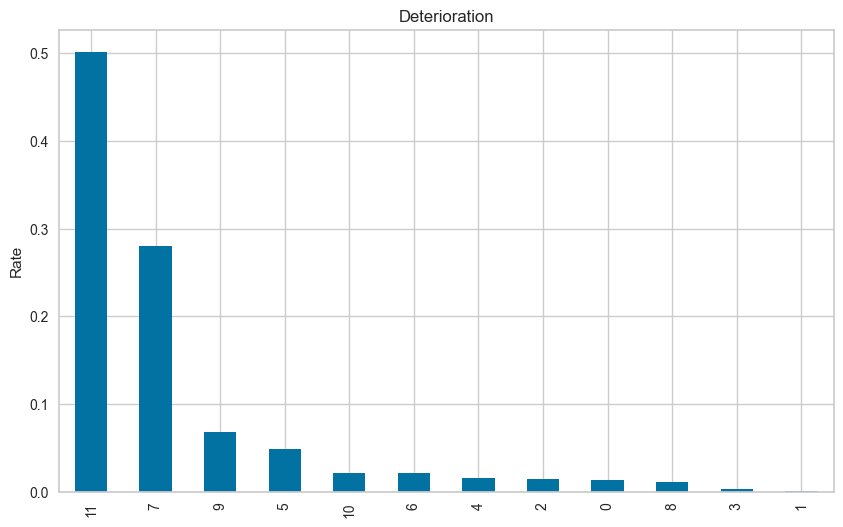

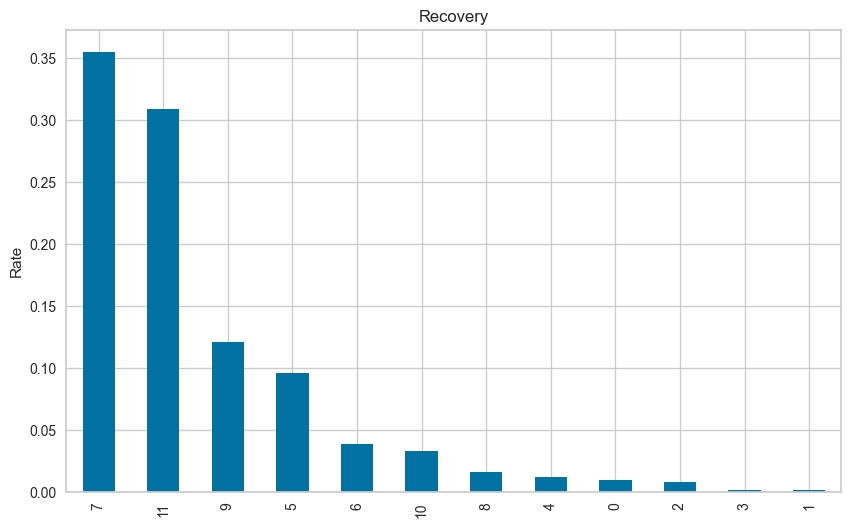

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns

# det_df의 Action 비율
det_action_counts = death_sample[death_sample['Annotation']=='circ']['Action'].value_counts(normalize=True)
det_action_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Deterioration')
plt.ylabel('Rate')
plt.show()

# re_df의 Action 비율
re_action_counts = live_sample[live_sample['Annotation']=='circ']['Action'].value_counts(normalize=True)
re_action_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Recovery')
plt.ylabel('Rate')
plt.show()

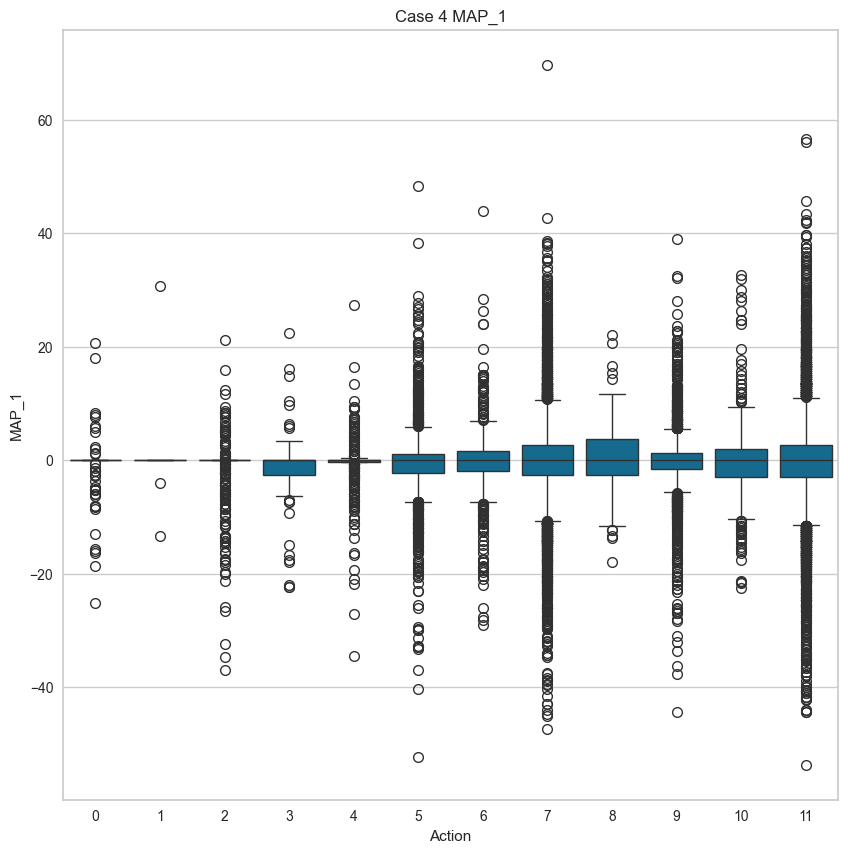

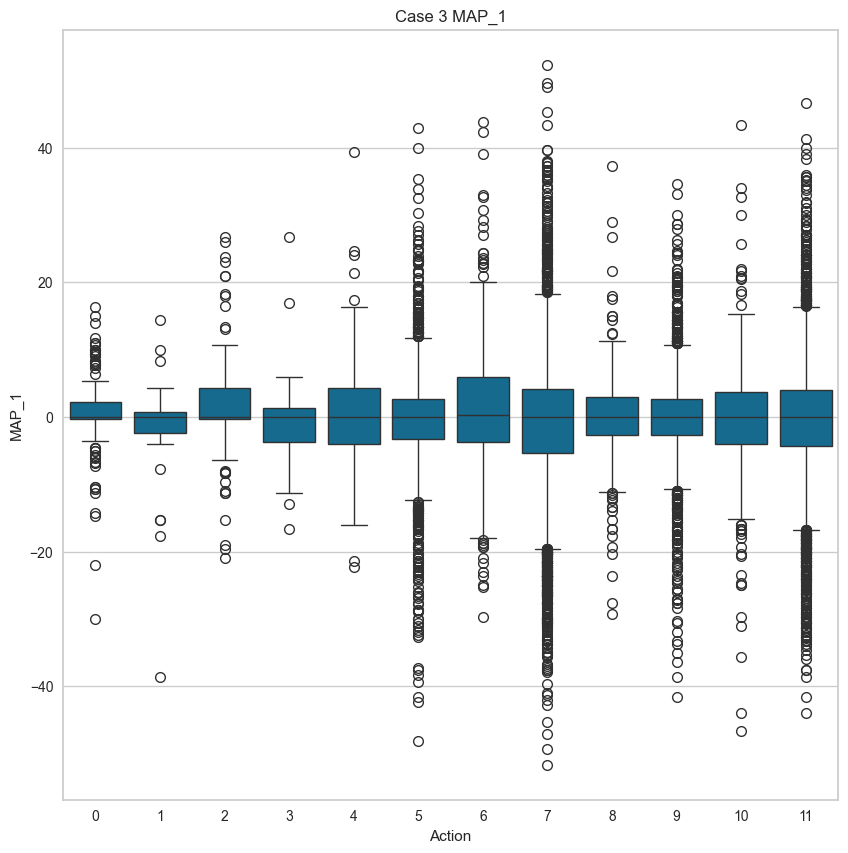

In [163]:
# det_df의 Action 별 Time_since_ICU_admission 분포
plt.figure(figsize=(10, 10))
sns.boxplot(x='Action', y='MAP_1', data=death_sample[death_sample['Annotation']=='circ'])
plt.title('Case 4 MAP_1')
plt.show()

# re_df의 Action 별 Lactate_3
plt.figure(figsize=(10, 10))
sns.boxplot(x='Action', y='MAP_1', data=live_sample[live_sample['Annotation']=='circ'])
plt.title('Case 3 MAP_1')
plt.show()

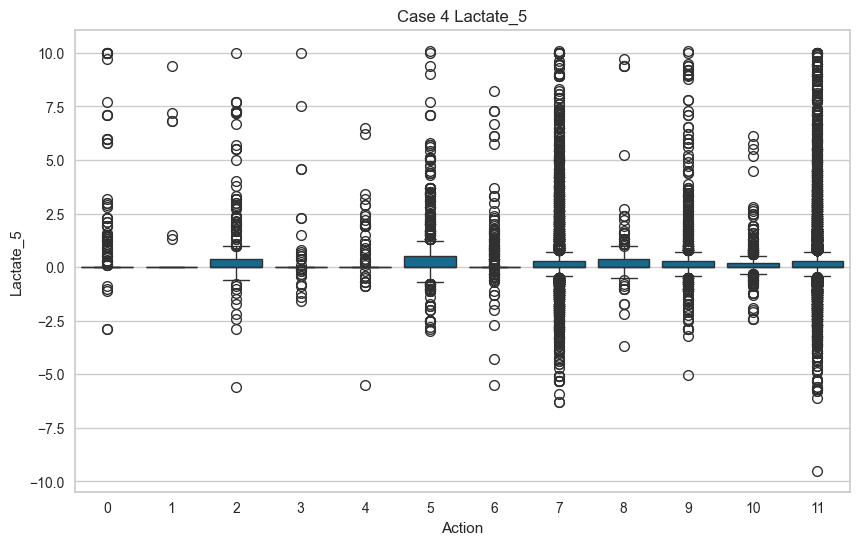

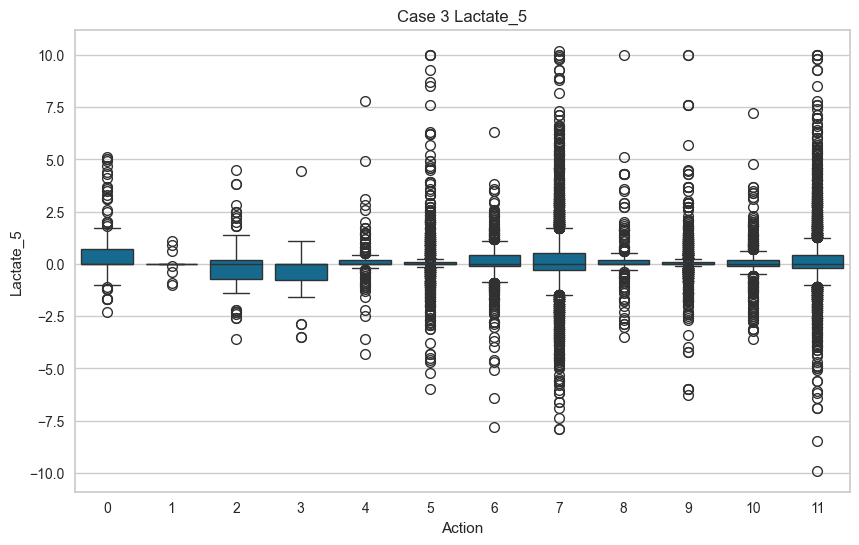

In [122]:
# det_df의 Action 별 Time_since_ICU_admission 분포
plt.figure(figsize=(10, 6))
sns.boxplot(x='Action', y='Lactate_5', data=death_sample[death_sample['Annotation']=='circ'])
plt.title('Case 4 Lactate_5')
plt.show()

# re_df의 Action 별 Lactate_5
plt.figure(figsize=(10, 6))
sns.boxplot(x='Action', y='Lactate_5', data=live_sample[live_sample['Annotation']=='circ'])
plt.title('Case 3 Lactate_5')
plt.show()

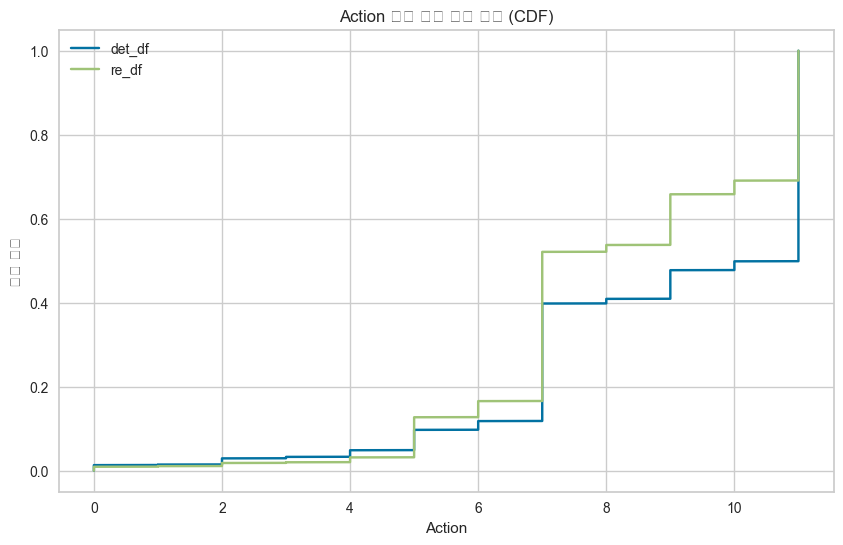

In [120]:
# 누적 분포 함수를 그리는 함수
def plot_cdf(data, label):
    sorted_data = np.sort(data)
    yvals = np.arange(len(sorted_data))/float(len(sorted_data)-1)
    plt.plot(sorted_data, yvals, label=label)

plt.figure(figsize=(10, 6))
plot_cdf(death_sample[death_sample['Annotation']=='circ']['Action'], 'det_df')
plot_cdf(live_sample[live_sample['Annotation']=='circ']['Action'], 're_df')
plt.title('Action 값의 누적 분포 함수 (CDF)')
plt.xlabel('Action')
plt.ylabel('누적 확률')
plt.legend()
plt.show()

In [77]:
from scipy.stats import chi2_contingency

# 두 데이터셋의 Action 빈도 계산
det_freq = death_sample[death_sample['Annotation']=='circ']['Action'].value_counts().sort_index()
re_freq = live_sample[live_sample['Annotation']=='circ']['Action'].value_counts().sort_index()

# 빈도 테이블 생성
freq_table = np.array([det_freq.values, re_freq.values])

# 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(freq_table)

print(f'Chi-square test 결과: chi2={chi2}, p-value={p}')

Chi-square test 결과: chi2=1995.3291729941059, p-value=0.0


In [164]:
import gc
gc.collect()

87404